# Using wandb

In [1]:
!pip install wandb -q

     |████████████████████████████████| 1.9 MB 12.8 MB/s 
     |████████████████████████████████| 168 kB 60.1 MB/s 
     |████████████████████████████████| 182 kB 56.9 MB/s 
     |████████████████████████████████| 62 kB 710 kB/s 
     |████████████████████████████████| 168 kB 64.5 MB/s 
     |████████████████████████████████| 166 kB 61.5 MB/s 
     |████████████████████████████████| 166 kB 61.2 MB/s 
     |████████████████████████████████| 162 kB 77.0 MB/s 
     |████████████████████████████████| 162 kB 16.8 MB/s 
     |████████████████████████████████| 158 kB 61.6 MB/s 
     |████████████████████████████████| 157 kB 66.1 MB/s 
     |████████████████████████████████| 157 kB 57.7 MB/s 
     |████████████████████████████████| 157 kB 27.2 MB/s 
     |████████████████████████████████| 157 kB 23.2 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 56.3 MB/s 
     |████████████████████████████████| 157 kB 22.0 MB/s 
     |██████████

In [2]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Text classification using LSTM and CNN.

In [3]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable

In [ ]:
import os
import re
import nltk
nltk.download("all")

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Download dataset

In [6]:
!wget http://cogcomp.org/Data/QA/QC/TREC_10.label -O test.label
!wget http://cogcomp.org/Data/QA/QC/train_5500.label -O train.label

--2022-12-14 15:23:36--  http://cogcomp.org/Data/QA/QC/TREC_10.label
Resolving cogcomp.org (cogcomp.org)... 173.236.182.118
Connecting to cogcomp.org (cogcomp.org)|173.236.182.118|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cogcomp.org/Data/QA/QC/TREC_10.label [following]
--2022-12-14 15:23:37--  http://www.cogcomp.org/Data/QA/QC/TREC_10.label
Resolving www.cogcomp.org (www.cogcomp.org)... 173.236.182.118
Reusing existing connection to cogcomp.org:80.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label [following]
--2022-12-14 15:23:37--  https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label
Resolving cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)... 158.130.57.77
Connecting to cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)|158.130.57.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23354 (23K)
Saving to: ‘test.label’

test

In [7]:
!head -n 10 train.label

DESC:manner How did serfdom develop in and then leave Russia ?
ENTY:cremat What films featured the character Popeye Doyle ?
DESC:manner How can I find a list of celebrities ' real names ?
ENTY:animal What fowl grabs the spotlight after the Chinese Year of the Monkey ?
ABBR:exp What is the full form of .com ?
HUM:ind What contemptible scoundrel stole the cork from my lunch ?
HUM:gr What team did baseball 's St. Louis Browns become ?
HUM:title What is the oldest profession ?
DESC:def What are liver enzymes ?
HUM:ind Name the scar-faced bounty hunter of The Old West .


In [8]:
!head -n 10 test.label

NUM:dist How far is it from Denver to Aspen ?
LOC:city What county is Modesto , California in ?
HUM:desc Who was Galileo ?
DESC:def What is an atom ?
NUM:date When did Hawaii become a state ?
NUM:dist How tall is the Sears Building ?
HUM:gr George Bush purchased a small interest in which baseball team ?
ENTY:plant What is Australia 's national flower ?
DESC:reason Why does the moon turn orange ?
DESC:def What is autism ?


fastText for word embedding

In [26]:
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2022-12-14 15:24:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  20.2MB/s    in 69s     

2022-12-14 15:25:32 (20.9 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


# Preprocessing

In [27]:
import codecs

In [28]:
def generate_examples(filepath):
    examples = []

    with codecs.open(filepath, "rb+") as f:
        for id_, row in enumerate(f):
            # ByteError in a sample
            label, _, text = row.replace(b"\xf0", b" ").strip().decode().partition(" ")

            coarse_label, _, fine_label = label.partition(":")

            examples.append((id_, {
                "label-coarse" : coarse_label,
                "label-fine" : fine_label,
                "text" : text,
            }))
    
    return examples

In [29]:
train = generate_examples("train.label")
test = generate_examples("test.label")

In [30]:
print(len(train))
print(train[0])

5452
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})


In [31]:

print(len(test))
print(test[0])

500
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})


In [32]:
label_list = list(set([item[1]["label-coarse"] for item in train]))

In [33]:
label_list

['ENTY', 'LOC', 'NUM', 'ABBR', 'HUM', 'DESC']

In [34]:
# Manual creating dict to match Huggingface labels.
label2idx = {
    "ABBR" : 0,
    "ENTY" : 1,
    "DESC" : 2,
    "HUM" : 3,
    "LOC" : 4,
    "NUM" : 5
}
idx2label = {
    0 : "ABBR",
    1 : "ENTY",
    2 : "DESC",
    3 : "HUM",
    4 : "LOC",
    5 : "NUM"
}

In [35]:
label2idx, idx2label

({'ABBR': 0, 'ENTY': 1, 'DESC': 2, 'HUM': 3, 'LOC': 4, 'NUM': 5},
 {0: 'ABBR', 1: 'ENTY', 2: 'DESC', 3: 'HUM', 4: 'LOC', 5: 'NUM'})

Concatenate and label data

In [36]:
texts = [text["text"] for id, text in train]
labels = [label2idx[text["label-coarse"]] for id, text in train]

In [37]:
from nltk.tokenize import word_tokenize
from collections import defaultdict
import numpy as np

In [38]:
def tokenize(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [39]:
def encode(tokenized_texts, word2idx, max_len):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

Load pretrained vectors, tokenizing

In [40]:
from tqdm import tqdm_notebook

In [43]:
def load_pretrained_vectors(word2idx, fname):
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [44]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


<ipython-input-43-9e8edf3086f1>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 9240 / 9435 pretrained vectors found.


# Create dataloader

In [45]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [46]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify = labels)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(
    train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

# Model

In [49]:
# Sample configuration:
filter_sizes = [3, 5, 7]
num_filters = [150, 150, 150]
hidden_units = 128
embed_dim = 200
hidden_dim = 100
dropout = .2
learning_rate = 1
epochs = 50
save_path = "checkpoint.pt"

In [50]:
wandb.init(config = {
    "filter_sizes" : filter_sizes,
    "num_filters" : num_filters,
    "hidden_units" : hidden_units,
    "embed_dim" : embed_dim,
    "hidden_dim" : hidden_dim,
    "dropout" : dropout,
    "lr" : learning_rate,
    "epochs" : epochs
},project="MultiChannelTextClassification")

wandb: Currently logged in as: trhgquan (khongsomeo). Use `wandb login --relogin` to force relogin


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_GRU(nn.Module):
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=200,
                 hidden_units=128,
                 hidden_dim=100,
                 filter_sizes=[3, 4, 5],
                 num_filters=[150, 150, 150],
                 num_classes=None,
                 dropout=0.5):

        super(CNN_GRU, self).__init__()

        assert pretrained_embedding is not None
        assert num_classes is not None

        # Embedding layer
        # self.embed_dim = embed_dim
        self.vocab_size, self.embed_dim = pretrained_embedding.shape
        self.embedding_cnn = nn.Embedding.from_pretrained(
            embeddings = pretrained_embedding,
            freeze = freeze_embedding
        )
        self.embedding_gru = nn.Embedding.from_pretrained(
            embeddings = pretrained_embedding,
            freeze = freeze_embedding
        )
        # self.embedding_cnn = nn.Embedding(num_embeddings=vocab_size,
        #                                   embedding_dim=self.embed_dim,
        #                                   padding_idx=0,
        #                                   max_norm=5.0)

        # self.embedding_gru = nn.Embedding(num_embeddings=vocab_size,
        #                                   embedding_dim=self.embed_dim,
        #                                   padding_idx=0,
        #                                   max_norm=5.0)

        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])

        self.gru = nn.GRU(
            input_size=self.embed_dim,
            hidden_size = hidden_units,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters) + hidden_units, hidden_dim * 2)
        self.sm = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):

        # ============ CNN ================
        x_embed_cnn = self.embedding_cnn(input_ids).float()

        x_reshaped = x_embed_cnn.permute(0, 2, 1)

        # Conv then ReLU
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        cnn_output = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # ============ GRU ================
        x_embed_gru = self.embedding_gru(input_ids).float()
        gru_out, (h_out, _) = self.gru(x_embed_gru)

        # Concatenate GRU output versus cnn output
        x_fc = torch.cat([h_out, cnn_output], dim = 1)

        first_fc = self.sm(self.fc1(x_fc))
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc2(self.dropout(first_fc))

        return logits

In [52]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=200,
                    hidden_units=128,
                    hidden_dim=100,
                    filter_sizes=[3, 4, 5],
                    num_filters=[150, 150, 150],
                    num_classes=None,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_GRU(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        hidden_units=hidden_units,
                        hidden_dim=hidden_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer


In [53]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, 
          optimizer, 
          train_dataloader, 
          val_dataloader=None, 
          epochs=10,
          save_path="checkpoint.pt"
          ):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                
                # Save best acc model.
                torch.save(model.state_dict(), save_path)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            wandb.log({'val_accuracy': val_accuracy, 'val_loss': val_loss, 'train_loss' : avg_train_loss})
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [54]:
# set_seed(42)
# cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
#                                         embed_dim=embed_dim,
#                                         hidden_units=hidden_units,
#                                         hidden_dim=hidden_dim,
#                                         learning_rate=learning_rate,
#                                         dropout=dropout,
#                                         num_classes=len(label_list))

# train(model = cnn_static_fasttext, 
#       optimizer = optimizer, 
#       train_dataloader = train_dataloader, 
#       val_dataloader = val_dataloader, 
#       epochs=epochs,
#       save_path = save_path)

In [55]:
set_seed(42)
cnn_static_fasttext, optimizer = initilize_model(pretrained_embedding=embeddings,
                                                 freeze_embedding=True,
                                                hidden_units=hidden_units,
                                                hidden_dim=hidden_dim,
                                                learning_rate=learning_rate,
                                                dropout=dropout,
                                                num_classes=len(label_list))

train(model = cnn_static_fasttext, 
      optimizer = optimizer, 
      train_dataloader = train_dataloader, 
      val_dataloader = val_dataloader, 
      epochs=epochs,
      save_path = save_path)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.605349   |  1.355170  |   32.52   |   5.17   
   2    |   0.902584   |  0.628648  |   80.88   |   0.72   
   3    |   0.450804   |  0.427992  |   85.70   |   0.73   
   4    |   0.271748   |  0.424226  |   85.63   |   0.60   
   5    |   0.171088   |  0.443502  |   86.47   |   0.71   
   6    |   0.083284   |  0.346475  |   90.03   |   0.70   
   7    |   0.042715   |  0.400002  |   87.41   |   0.61   
   8    |   0.023459   |  0.345990  |   90.19   |   0.69   
   9    |   0.015013   |  0.361287  |   89.54   |   0.62   
  10    |   0.007474   |  0.358874  |   90.56   |   0.72   
  11    |   0.004284   |  0.363417  |   90.08   |   0.62   
  12    |   0.005099   |  0.375089  |   90.47   |   0.61   
  13    |   0.003423   |  0.374230  |   90.08   |   0.59   
  14    |   0.004374   |  0.387685  |   89.92   |   0.60   
  15    |   0.004281

# Evaluation

Load state dict

In [56]:
# best_checkpoint = CNN_GRU(vocab_size=len(word2idx),
#                             embed_dim=embed_dim,
#                             hidden_units=hidden_units,
#                             hidden_dim=hidden_dim,
#                             dropout=dropout,
#                             num_classes=len(label_list)).to("cpu")

In [57]:
best_checkpoint = CNN_GRU(pretrained_embedding=embeddings,
                          freeze_embedding=True,
                            embed_dim=embed_dim,
                            hidden_units=hidden_units,
                            hidden_dim=hidden_dim,
                            dropout=dropout,
                            num_classes=len(label_list)).to("cpu")

In [58]:
best_checkpoint.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [59]:
def predict(text, model, max_len = 62):
    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = torch.argmax(F.softmax(logits, dim=1).squeeze(dim=0))

    return probs.item()

In [60]:
print(f"Question: {test[0][1]['text']}")
print(f"Label: {test[0][1]['label-coarse']}")
print(f"Predicted: {idx2label[predict(model = best_checkpoint, text = test[0][1]['text'])]}")

Question: How far is it from Denver to Aspen ?
Label: NUM
Predicted: NUM


In [61]:
def eval_testset(model):
    correct_label = []
    predicted_label = []
    
    for key, val in test:
        correct_label.append(label2idx[val["label-coarse"]])
        predicted_label.append(predict(val["text"], model))
    
    return predicted_label, correct_label

## Evaluate for cnn_rand

In [62]:
y_pred_cnn_rand, y_true_cnn_rand = eval_testset(best_checkpoint)

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
print(classification_report(y_true_cnn_rand, y_pred_cnn_rand, target_names = label2idx.keys()))

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        ENTY       0.89      0.83      0.86        94
        DESC       0.97      0.95      0.96       138
         HUM       0.82      0.95      0.88        65
         LOC       0.91      0.99      0.95        81
         NUM       0.93      0.88      0.90       113

    accuracy                           0.91       500
   macro avg       0.92      0.90      0.90       500
weighted avg       0.92      0.91      0.91       500



In [65]:
print(f"Accuracy: {accuracy_score(y_true_cnn_rand, y_pred_cnn_rand):.6f} \n \
Precision (macro): {precision_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} \n \
Recall (macro): {recall_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} \n \
F1 score (macro): {f1_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f}")


Accuracy: 0.914000 
 Precision (macro): 0.919263 
 Recall (macro): 0.895741 
 F1 score (macro): 0.903690


In [66]:
print(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand))

[[  7   0   2   0   0   0]
 [  0  78   1  10   1   4]
 [  0   4 131   0   0   3]
 [  0   2   0  62   1   0]
 [  0   1   0   0  80   0]
 [  0   3   1   4   6  99]]


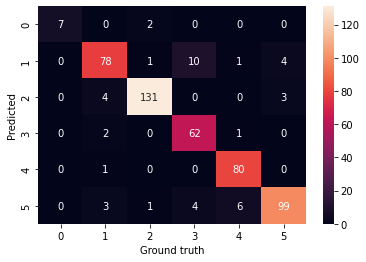

In [67]:
sns.heatmap(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [68]:
for text, pred, truth in zip(test[0:10], y_pred_cnn_rand[0:10], y_true_cnn_rand[0:10]):
    print(f"{text[1]['text']} -- {idx2label[pred]} -- {idx2label[truth]}")

How far is it from Denver to Aspen ? -- NUM -- NUM
What county is Modesto , California in ? -- LOC -- LOC
Who was Galileo ? -- HUM -- HUM
What is an atom ? -- DESC -- DESC
When did Hawaii become a state ? -- NUM -- NUM
How tall is the Sears Building ? -- NUM -- NUM
George Bush purchased a small interest in which baseball team ? -- HUM -- HUM
What is Australia 's national flower ? -- ENTY -- ENTY
Why does the moon turn orange ? -- DESC -- DESC
What is autism ? -- DESC -- DESC


In [69]:
wandb.finish()

train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▇████████████████████████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.00019
val_accuracy,90.28381
val_loss,0.45617
